# 第６回：Chainer入門

## 到達目標
* Chainerを使って全結合のニューラルネットを記述し、実行することができる
* ニューラルネットとその他の手法との関係性とその特性の差を理解する
* ニューラルネットの基本的な学習テクニックを学ぶ

## キーワード
* Chainer
* Define-by-Run
* Link, Chain, Optimizer

## タイムスケジュール
### 前回の復習 (5分)
### 講義・基礎演習 (85分)
#### Part 1. Chainer入門 (50分)
##### 講義 (10分)
* Chainerとは
* "Define-and-Run"と"Define-by-Run"
* Chainerの特長と他フレームワークとの比較
* 計算グラフの記述
* (GPUへの対応)
##### 基礎演習 (40分)
* Variable
* 自動微分
* Link
* Chain
* L.Linear, F.relu, F.softmax\_cross\_entropy
* 多層パーセプトロンのChainerによる記述
* Optimizer
* (Trainerを用いない)ニューラルネットの学習
* モデルの保存と読み込み (Serializer)
* (Trainer/Updater)
* (datasets/iterators)
* (Extension(Evaluator, LogReport, PrintReport, ProgressBar, snapshot))
* (Trainerを用いた)ニューラルネットの学習
* (GPU対応コードの実装)
* 課題:Chainerを用いたロジスティック回帰の実装

#### Part 2. ニューラルネットの学習テクニック (15分)
* NNの最適化手法(Momentum法(MomentumSGD)/AdaGrad/Adam)
* NNの正則化手法(Dropout)
* 勾配消失問題
* Heの初期化
* Batch Normalization

#### Part 3. 他手法との比較 (20分)
* 汎化誤差・交差検証 (復習)
* 機械学習モデルの性能を決める要素 (特徴選択・前処理・線形性)
* SVMとNNの比較
* モデル選択


# Chainerとは？

## 日本製のディープラーニングフレームワーク
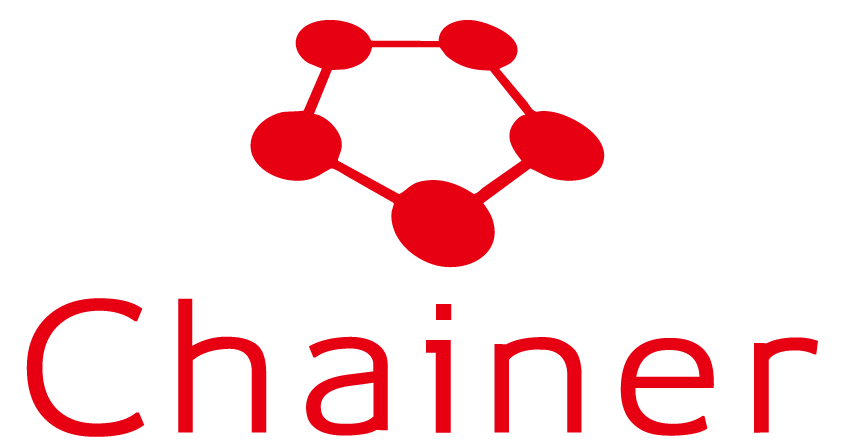

**Chainer**は日本の企業である**Preferred Networks**社が開発をすすめるディープラーニング（ニューラルネットワーク）に特化したPythonで使用できるフレームワークです。
他にも、Googleが提供するTensorFlowやそのラッパーのKerasもあり、個人的には日本ではこのどちらかを使っている人が多いかなと感じます。

**Chainerはもともと習得が簡単なインターフェースで作られている面**と、他のフレームワークに比べて、ディープラーニングの開発を論文レベルだったりの**カスタマイズをする際に非常に柔軟に対応できる**といった点が魅力に感じています。

## 特徴は「Define by Run」
**Define by Run**と呼ばれる仕組みがGoogleのTensorFlowをはじめとした他のフレームワークとの大きな違いであり、初心者にとっては、**学習途中に数値やサイズの確認が出来るといったデバックの容易さ**がメリットです（Chainerの開発者から直接聞きました）。  
たしかに、**学習途中にどのような挙動をしているか、どこでエラーが起きているか**は開発者にとっては非常に大事なため、この構造を採用しているのは、大きなメリットだと感じます。

## Chainerでわからないことがあれば、開発者にSlackで聞こう！

ChainerではPFNの開発者にダイレクトに質問できるSlackがあり、セミナー参加者は正体大歓迎とPFNの方も言ってくださっているので、ぜひ[こちら](https://docs.google.com/forms/d/e/1FAIpQLSfqL9XjnqZUIwLOz4K9Oxm8-Ce246IRP51-vZa7HOrofJT9rA/viewform)からメールアドレスを登録して、Slackに招待してもらいましょう。  
[**▶ Chainer Slack 受付フォーム**](https://docs.google.com/forms/d/e/1FAIpQLSfqL9XjnqZUIwLOz4K9Oxm8-Ce246IRP51-vZa7HOrofJT9rA/viewform)

## 計算グラフの記述
まずは、３ノードの入力層と２ノードの出力層の部分を表現していきましょう。
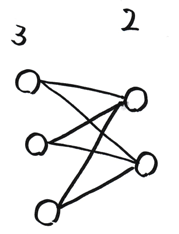
ノードの結合を表す時は、chainer.linksを使用します。
そして、このchainer.linksをLとして宣言するので、覚えておきましょう（公式リファレンス推奨の方法）

In [2]:
import chainer.links as L

3 -> 2 のリンクをl1として、以下のように宣言します。

In [3]:
l1 = L.Linear(3, 2)

これだけで完了です。
L.Linearの意味は、みなさんが勉強されてた重回帰分析の線形結合という意味です。

そして、宣言したリンクの重み（W）とバイアス（b）はランダムに初期化されています。

In [4]:
l1.W

variable W([[ 0.32169408, -0.9133054 , -1.17567265],
            [ 0.44504353,  0.70877433, -0.44179112]])

In [5]:
l1.b

variable b([ 0.,  0.])

このランダムに初期化されたパラメータを最適化の初期値に使用します。

Chainerの中で必要な基礎はこのリンクの書き方を抑えておけば、一旦OKです。
他にも色々な機能がありますが、これは次の実践的な非線形回帰を試しながら、見ていきましょう。

# Chainerでワインのクラス分類を行おう
実際の問題を想定しながら、Chainerの使い方を見ていきましょう。

## モデルを定義しよう
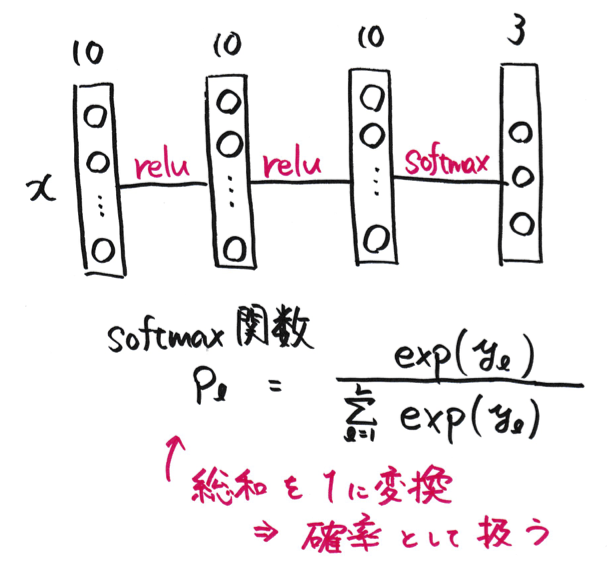
Chainerでは、まずモデルの定義を行います。
今回は下記のような、４層のニューラルネットワーク（NN）の作り方を学びましょう。

まず、Chainerのモデルの中で使用するchainer.functionsを読み込んでおきましょう。

In [26]:
import chainer
import chainer.functions as F

chainer.fuinctionsでは、F.reluとして**Relu関数**や、F.mean_squared_errorとして**平均二乗誤差（Mean Squared Errors）**、F.softmax_cross_entropyとして**ソフトマックスクロスエントロピー**の計算など、ニューラルネットワークでよく使用する関数が定義されています。

そして、今回の４層のモデルをChainerでは以下のように書きます。

In [27]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

少し多いため戸惑いますが、基本的には雛形に分類の問題はカスタマイズするだけで実装できるため、カスタマイズするポイントを覚えておきましょう。

- `__init__`：モデルの構造を宣言
- `__call__`：評価関数を宣言

他にも書き方（この自由度の高さがChainerの魅力の１つ）がありますが、簡単なモデルの場合はこのような構造で書いておくことをおすすめします。

`__init__`内にモデルの構造を書き、`__call__`内でそれをつなぎ合わせるイメージです。

### Chainerでは定義するモデルとClassifierを繋げて使う
これは、Chainer流の書き方に合わせるためですが、基本的には、Chainerの分類を書く際には、以下の２つのモデルに分けることが多いです。

- 順伝播で予測値を計算（推論）を行うモデル　←　今回のMLP
- 予測値から評価関数を計算するモデル　←　この後のL.Classifier

この書き方は絶対というわけではありませんが、この書き方を覚えておくと、リファレンスを見た際の対応関係がわかりやすいため、おすすめです。

評価関数を計算する部分である L.Classifier は既にChainer側で準備されており、その中でSoftmax関数に変換して計算を行ってくれます。

### モデル宣言の際の注意

また、モデルの宣言の前に気をつけないといけないことがあります。

Chainerのchainer.linksで宣言したL.Lienarの中では宣言したタイミングで、重みWやバイアスbがランダムに初期化されていました。
そのため、実行毎に結果が異なってしまい、「昨日うまくいったのに、全く同じプログラムでも今日はうまくいかない」といったことがあり得ます。

この対策として、**乱数のシード**を固定することがあります。
乱数のシードを固定しておくと、毎回同じ結果が得られ、**再現性の確保**ができます。

**これはデータ解析の際には非常に重要なため、絶対に忘れないようにしましょう。**

Chainerが使用する乱数のシードはPython標準のrandomではなく、Numpyの中で使用されているnumpy.randomであるため、お気をつけください。

In [92]:
import numpy as np

つぎに、Numpyの乱数のシードを固定しましょう。

In [93]:
# シードの固定
np.random.seed(1)

そして、モデルを実際に使っていく際には、下記のように宣言をします。

In [94]:
# NNモデルに必要なパラメータの設定
n_units1 = 10
n_units2 = 10
n_output = 3

In [95]:
# NNモデルの宣言
mlp = MLP(n_units1, n_units2, n_output)

# 分類用にラップ
model = L.Classifier(mlp)

NNモデルの中で、ノードの数を直に書いて宣言しても良いのですが、こちらのように、ノードの数を**引数**としておくことで、柔軟に変更できるため、こちらの書き方がおすすめです。

## Optimizerを定義しよう

Chainerではoptimizerと呼ばれる最適化を担当する部分のモジュールがあります。
最適化とは**最急降下法**、**確率的勾配法（SGD)**などのアルゴリズムのことです。

optimizerはchainer.optimizersにあるため、こちらを読み込みましょう。

In [96]:
from chainer import optimizers

In [97]:
# 最適化のアルゴリズムには SGD を使用
optimizer = optimizers.SGD()

定義したoptimizerと作成したmodelを紐付けるために、optimizer.setup(model)が必要となるため、忘れないようにしましょう。

一番シンプルな場合は、このモデルの宣言とoptimizerの宣言で完了です。

In [98]:
optimizer.setup(model)  # modelと紐付ける

## データを準備しよう
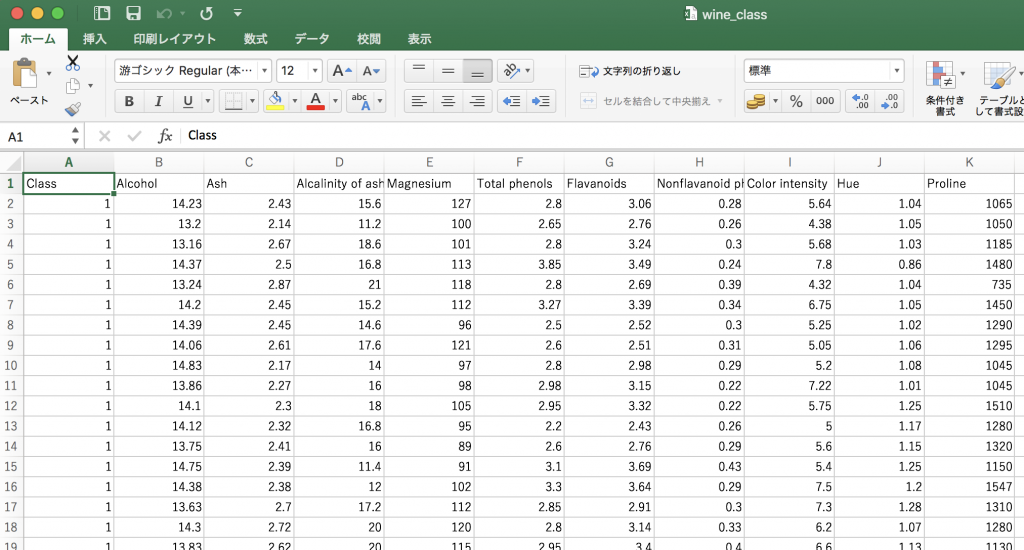

### CSVファイルからの読み込み

**CSVファイル**とは聞き慣れている方も多いかと思いますが、データが**カンマ区切り**で表現されているデータのことです。

**wine_class.csv**のファイルを準備しているので、こちらを読み込んでみましょう。

### Pandasで読み込み
CSVファイル含め、データの読み込みには**Pandas**と呼ばれる外部モジュールを使用すると便利です。
整理をしておくと、データ解析の基礎となる３つのツールの位置づけはこちらです。

- Numpy：数値データの取り扱い（線形代数含め）
- Pandas：データベースの操作（小規模のCSVファイル含め）
- Matplotlib：プロット

特に、PandasはJupyter Notebookとの相性も良く、綺麗に表を表示することができるため、おすすめです。

まず、Pandasを読み込みましょう。

In [99]:
import pandas as pd

In [100]:
# ローカルのファイルから読み込む
df = pd.read_csv('wine_class.csv')

**df** は **data frame** の略であり、pandasの例でよく出てくる名前ですので、覚えておきましょう。

Pandasで読み込んだデータはdfで内容を確認でき、df.head()と実行すると、先頭の5つが表示され、長すぎないのでおすすめです。
なお、df.head(10)とすると、先頭の10個が表示されます。

In [101]:
df.head(10)

,Class,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,1,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,1,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,1,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,1,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735
5,1,14.20,2.45,15.2,112,3.27,3.39,0.34,6.75,1.05,1450
6,1,14.39,2.45,14.6,96,2.50,2.52,0.30,5.25,1.02,1290
7,1,14.06,2.61,17.6,121,2.60,2.51,0.31,5.05,1.06,1295
8,1,14.83,2.17,14.0,97,2.80,2.98,0.29,5.20,1.08,1045
9,1,13.86,2.27,16.0,98,2.98,3.15,0.22,7.22,1.01,1045


各カラムを抽出する場合は、辞書型のようにカラム名を指定すればOKです。

In [102]:
df['Class'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Class, dtype: int64

また、.valuesと付けると、Pandasの形式からNumpyの形式に変換でき、これをよく用います。
理由として、ChainerやScikit-learnのライブラリでは、Numpyの形式で保存された変数を前提に設計されていることが多いため、データの抽出が終わった最後に、.valuesを付けてNumpyの形式に変換しておくと無難です

In [103]:
df['Class'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

また、入力変数が多い場合など、手動でカラム名を全部指定することが面倒なときは、df.ilocを使用すると、Numpy含めた行列の表現として抽出することができます。

例えば、全ての行（:）で１〜２列目（0:2）を抽出したい場合は以下のようになります。

In [104]:
df.iloc[:, 0:2].head(10)

,Class,Alcohol
0,1,14.23
1,1,13.20
2,1,13.16
3,1,14.37
4,1,13.24
5,1,14.20
6,1,14.39
7,1,14.06
8,1,14.83
9,1,13.86


## 入力変数と出力変数に分ける

今回はワインの成分から等級を分類するといった問題設定であるため、

- 入力変数：AlcoholからProlineまでの数値データ
- 出力変数：Class

を採用します。

先ほど紹介したdf.ilocを使用してデータを切り分けましょう。

In [105]:
_x = df.iloc[:, 1:].values
_t = df.iloc[:, 0].values - 1  # chainerのラベル付けは0スタートのため、等級は1からではなく、0から始めておく

また、Chainerで使用する際には、

- 実数値：np.float32
- 整数値：np.int32

に変換しておかないとよくエラーがでるため、事前にこちらへ変換しておきましょう。

In [106]:
x = np.array(_x, dtype=np.float32)
t = np.array(_t, dtype=np.int32)

※ 一時的に保存する変数名に_xのようにアンダーバー（アンダースコア）を付けています。

## Variableに変換
Chainerを使う時になかなか難しいのが変数の取り扱いです。  
Chainerでは、chainer.Variableで定義されている変数の方に変換してから、モデルの学習用に使います。

In [107]:
from chainer import Variable

In [108]:
# Chainer用の変数として宣言
x_ch = Variable(x)
t_ch = Variable(t)

## モデルを学習させよう

モデル学習の流れは以下のとおりです。

> 順伝播の計算　▶　勾配の計算　▶　パラメータの調整

これをforでループさせ、評価関数の値が小さくなるように、パラメータをどんどん調整していきます。

それでは、学習ループのプログラムを書いていきましょう。

In [109]:
# 1000回順伝播と逆伝播を繰り返す
for i in range(1000):
    
    # 勾配情報の初期化（chainerの仕様）
    model.cleargrads()
    
    # 順伝播（評価関数の計算）
    loss = model(x_ch, t_ch)
    
    # 勾配（傾き）の計算 <-　誤差逆伝播法が使用されている
    loss.backward()
    
    # パラメータの調整
    optimizer.update()

基本的には最初に提示した流れをforで所定回数繰り返しています。

唯一、model.cleargrad()という項があり、これはChainerの仕様なのですが、学習の前に勾配を保存している変数を初期化する必要があります。
ただ、こちらは「Chainerの仕様」であるため、特に気にせず、毎回書くものだと思っておいてください。

loss = model(x_ch, t_ch)の項では、modelを関数風に呼び出しているため、modelの`__call__`の関数が呼び出されており、評価関数の値が計算されています。

そして、その計算した評価関数をもとに、loss.backward()とすると、不思議ですが、model内のパラメータWとbの勾配に関するアトリビュートであるmodel.W.gradや model.b.gradに最新の勾配の値が代入されるようになっています。
このあたりは「なぜ？」というよりも「Chainerの仕様だから」と片付けてしまう方が良いと思います。
最初に説明した**Define by Run**を実現するための構造であったりします。

また、上記の学習のプログラムでは、学習の経過の様子がわからないため、lossを保存するリストを準備してみましょう。

In [110]:
losses = []  # 追記：訓練結果保存用のリスト
for i in range(1000):
    model.cleargrads()
    loss = model(x_ch, t_ch)
    loss.backward()
    optimizer.update()
    # 追記：プロットするように保存しておく
    losses.append(loss.data)

これで学習した結果を保存できるため、どれくらい評価関数の値（平均二乗誤差）が下がっているかプロットして確認しましょう。

プロットには**Matplotlib**を使いましょう。

In [111]:
import matplotlib.pyplot as plt

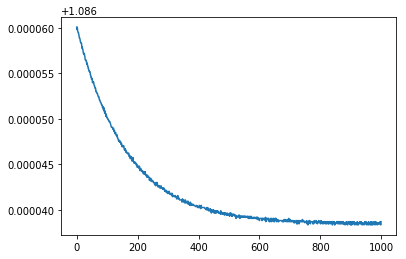

In [112]:
# 評価関数の値をプロット
plt.plot(losses)
plt.show()

## 結果を確認しよう
それでは、まだ学習させることで良くなりそうですが、現状のモデルに対して、どの程度うまくいっているかを目視で確認してみましょう。
目視では、定量的な厳密性のある議論ができませんが、そもそも全くうまくいっていないことは瞬時に判断することができるため、最初は目視による確認から入ることがおすすめです。

まず、現状のモデルで予測値の計算（推論）を行いましょう。  
※ まず１番目のデータに対する計算です。

In [134]:
y = mlp(x_ch[None, 0]).data

ちなみに、mlp(x[0])と書かずに、mlp(x[None, 0])と書くことに違和感があると思いますが、Chainerでは一行目にバッチサイズが来ないといけないため、こちらを変換する必要があります。
こちらを変更するための書き方は下記のように複数あります。

- x[None, 0]
- x[0].reshape(1, len(x[0]))
- np.array([x[0]])

一番シンプルな書き方がx[None, 0]であるため、こちらを使用することをおすすめします。
※ PFNの方もこちらの書き方でした。

ここで、Chainerで定義したmodelから得られる計算の値はChainerのVariableで得られるため、数値として取り扱うために.dataでnumpyの形式で数値を取り出しています。

推論した結果は以下のとおりです。

In [135]:
y

array([[ 0.00681615,  0.19196831, -0.1987845 ]], dtype=float32)

こちらのように、クラスの予測値が出てきてくれるわけではなく、回帰の結果が出力されています。

In [136]:
y = F.softmax(y).data

In [137]:
y

array([[ 0.3313936 ,  0.39879954,  0.2698068 ]], dtype=float32)

In [138]:
np.argmax(_y)

1

こちらのように、softmax関数にかけた後に、np.argmaxで確率が最大のインデックスが取得でき、こちらが該当するクラスになります。

# Trainerを使おう
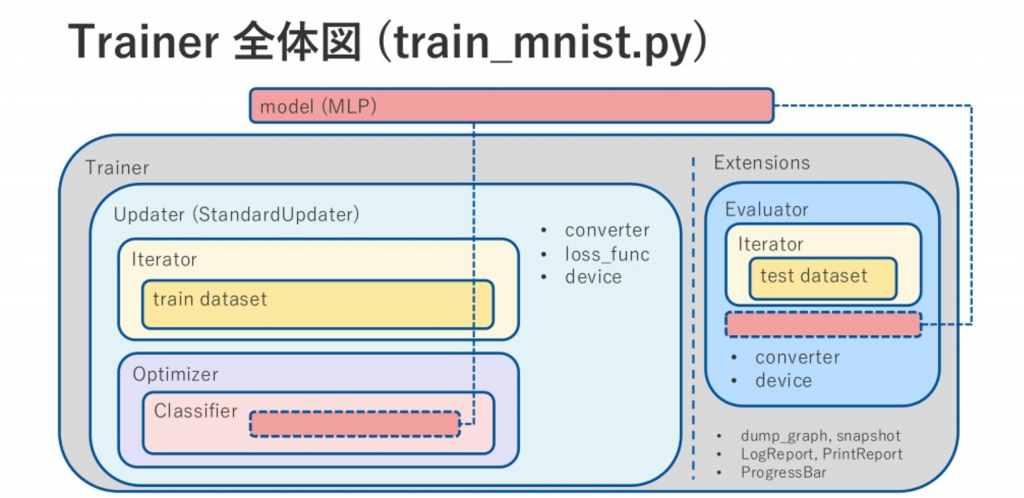

## Trainerとは？
先ほどの講義では、実際にカスタマイズすべき点の挙動も確認しながら、Chainerの使い方を見てきましたが、この方法では実務に入る際に問題点があります。

- バッチサイズの指定を学習ループのfor文にいちいち書かないといけない（結構めんどくさい）
- 検証用データに対する結果を計算するために、追記しないといけない（結構めんどくさい）
- ループしている状況を可視化して確認したい際には print などでいちいち確認するためのコードを書かないといけない（これが入るとコードの本質を見失う）
- 訓練データと検証データで時系列的にどの程度誤差が下がっているか確認するためのコードも書かないといけない（これを見ないと、オーバーフィッティングに気づけないため必須）
- etc…

といったように、先ほどまでの手順で使えるようになるのと、実用化を視野に入れるのでは、結構なレベルの差が合ったりします。

この部分をサポートしてくれているのがChainerのTrainerです。

In [165]:
# 乱数のシードを固定 (再現性の確保)
np.random.seed(1)

# モデルの宣言
n_units1, n_units2, n_output = 10, 10, 3
mlp = MLP(n_units1, n_units2, n_output)
model = L.Classifier(mlp)

# optimizerの設定
optimizer = optimizers.Adam()
optimizer.setup(model)

## Datasetの設定

Trainerを使用する際は、Variableにデータを変換するといった手順は省略できます。
その代わり、データを所定の形式に変換しておく必要があります。

メモリに乗り切る程度の小規模なデータの際は、**入力変数と教師データをタプルで１セット**にして、それを**リスト化**しておくことがChainer推奨の方法だそうです。
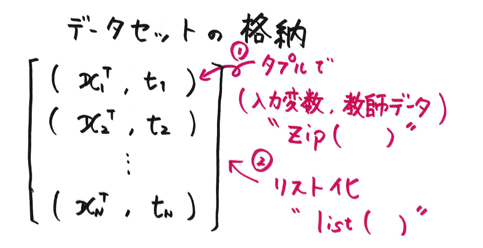

In [166]:
dataset = list(zip(x, t))

こちらのように、zip(x, t)で入力変数と教師データをタプル化した後、それをlistでリスト化します。
こちらは毎回同じ記述であるため、このように書くと覚えておいていただければOKです。

In [167]:
dataset

[(array([  1.42299995e+01,   2.43000007e+00,   1.56000004e+01,
           1.27000000e+02,   2.79999995e+00,   3.05999994e+00,
           2.80000001e-01,   5.63999987e+00,   1.03999996e+00,
           1.06500000e+03], dtype=float32), 0),
 (array([  1.31999998e+01,   2.14000010e+00,   1.11999998e+01,
           1.00000000e+02,   2.65000010e+00,   2.75999999e+00,
           2.59999990e-01,   4.38000011e+00,   1.04999995e+00,
           1.05000000e+03], dtype=float32), 0),
 (array([  1.31599998e+01,   2.67000008e+00,   1.86000004e+01,
           1.01000000e+02,   2.79999995e+00,   3.24000001e+00,
           3.00000012e-01,   5.67999983e+00,   1.02999997e+00,
           1.18500000e+03], dtype=float32), 0),
 (array([  1.43699999e+01,   2.50000000e+00,   1.67999992e+01,
           1.13000000e+02,   3.84999990e+00,   3.49000001e+00,
           2.39999995e-01,   7.80000019e+00,   8.60000014e-01,
           1.48000000e+03], dtype=float32), 0),
 (array([  1.32399998e+01,   2.86999989e+00,   2.100

## 訓練データと検証データに分割

Chainerではデータセットをランダムに分割に関する関数が準備されており、chainer.datasets.split_dataset_randomです。  
※ 詳しくは[こちら](https://docs.chainer.org/en/stable/reference/generated/chainer.datasets.split_dataset_random.html#chainer.datasets.split_dataset_random)のリファレンス参照
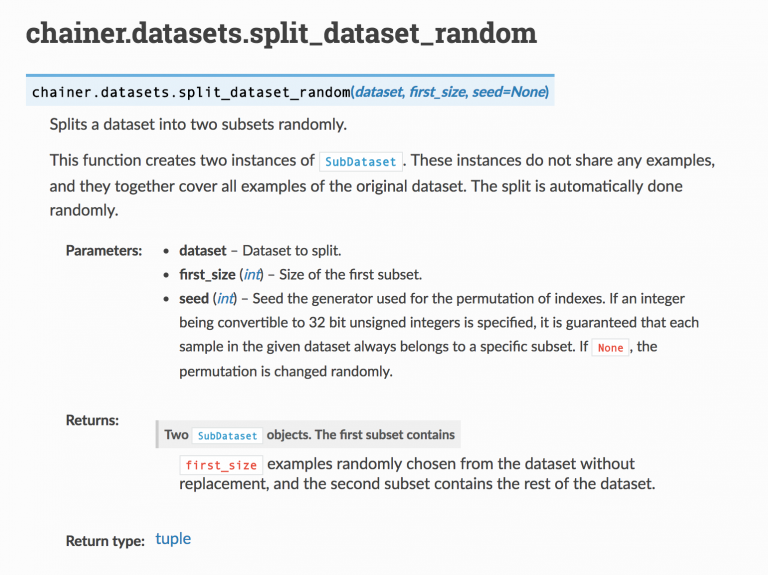

Prameterには、dataset（先ほど作成した形式）とfirst_sizeと指定されています。

first_sizeでは訓練データのサイズを指定するのですが、こちらの指定をする際に、全体の70%を訓練データにしようと決めておくと記述が簡単かつ汎用性の高いプログラムになります。

全体のサイズを取得する時にはlen()が便利です。

In [169]:
len(dataset)

178

split_dataset_randomを使用したtrainとtestの分割は以下のようになります。

In [170]:
from chainer.datasets import split_dataset_random

n_train = int( len(dataset) * 0.7 )  # 訓練データのサイズ
train, test = split_dataset_random(dataset, n_train, seed=1)

n_trainを計算する際に、intと付けていますが、サイズは整数値しか受け付けないため、少数が出た際にはintによって小数値の切り捨てをおこなっています。

また、seed=1は乱数のシードを1で固定しますといった意味で、何度か出てきている再現性確保のためです。

出力として得られるtrainとtestを確認してみると、

In [171]:
train

と表示されるため、「あれ？数値はどこにいったのかな」と迷いますが、train[0]のようにリストの要素番号を指定すると、数値が表示され、リスト形式で保存されていることがわかります。  
※このあたりは、なかなかリファレンスがなかったりするため、挙動を確認しながら進めていくことが必要です。

In [172]:
train[0]

(array([  1.36899996e+01,   2.53999996e+00,   2.00000000e+01,
          1.07000000e+02,   1.83000004e+00,   5.60000002e-01,
          5.00000000e-01,   5.88000011e+00,   9.59999979e-01,
          6.80000000e+02], dtype=float32), 2)

In [173]:
test

In [174]:
test[0]

(array([  12.17000008,    2.52999997,   19.        ,  104.        ,
           1.88999999,    1.75      ,    0.44999999,    2.95000005,
           1.45000005,  355.        ], dtype=float32), 1)

In [175]:
len(train)

124

In [176]:
len(test)

54

## Iteratorの設定

**Iterator**では「**バッチサイズ**」を決めることができます。

順伝播で評価関数を計算する際に、全てのサンプルを使用するのではなく、基本的には、**ミニバッチ**と呼ばれるサンプルの一部のデータセットのみで、評価関数の計算を行い、逆伝播で勾配情報を計算し、最適化アルゴリズム（SGDやAdam等）によりパラメータの学習を行います。

### ミニバッチを採用する理由

たとえば、10万サンプルある場合は、10万回順伝播を計算して、初めて1回パラメータ更新できるといったように、サンプル数が多ければ多いほど１回あたりのパラメータ更新にかかる時間が長くなってしまうといった問題を避けられます。
バッチサイズを10としておけば、ほとんど同じ計算負荷でも1万回のパラメータ更新を行うことができます（厳密には逆伝播が毎回走るため同じ計算負荷ではない）。

また、もう一つの理由として、ミニバッチに分けて最適化を行うことで、局所最適解に陥ることを避けられると言われています。

今回はこのバッチサイズを20と設定して行きます。

In [177]:
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter  = chainer.iterators.SerialIterator(test,  batchsize, repeat=False, shuffle=False)

## Updaterの設定

Updaterでは、Optimizerの設定や、使用するデバイス（CPUやGPU）の設定を行えます。

- CPUを使用する場合には、device=-1とオプションに指定しましょう。
- GPUを使用する場合には、device=0（GPUを複数枚さしている場合はdevice=1なども存在）とオプションで明示しておきましょう。

deviceを特に指定しない場合には、CPUが使用されます。

In [178]:
from chainer import training
updater = training.StandardUpdater(train_iter, optimizer, device=-1)
# updater = training.StandardUpdater(train_iter, optimizer)

## Trainerとextensionsの設定
Trainerでは、**エポック（ミニバッチを全て処理して１エポック）**の回数や、そのextensionsでオプションを指定することにより、**結果をログ出力や標準出力（インタラクティブに表示）**もできたりします。

In [179]:
# trainerとそのextensionsの設定
from chainer.training import extensions

# trainerの基本設定
epoch = 1000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに、trainデータに対するlossと、testデータに対するloss、経過時間（elapsed_time）を標準出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

## 学習の実行
色々と設定を行い、Trainerでは最後に trainer.run() でOKです。

In [180]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           15.7672     14.2523               0.0204601     
2           13.3503     12.5375               0.0347712     
3           12.0078     11.0668               0.049818      
4           10.174      9.61617               0.0651011     
5           8.77633     8.20031               0.0863202     
6           7.47279     6.46364               0.101881      
7           5.65272     4.9057                0.115553      
8           4.37566     3.70569               0.131015      
9           2.96045     2.68607               0.144884      
10          2.18111     1.88635               0.163925      
11          1.71607     1.49578               0.187345      
12          1.42262     1.37366               0.208987      
13          1.35401     1.23788               0.22583       
14          1.19969     1.13354               0.240829      
15          1.12737     1.06224               0.255255      
16          1.10141     1.

138         0.47645     0.549767              2.14035       
139         0.466221    0.546844              2.15502       
140         0.453238    0.543169              2.17237       
141         0.466437    0.544094              2.19195       
142         0.453863    0.540932              2.20728       
143         0.478548    0.557772              2.22347       
144         0.453366    0.549596              2.24312       
145         0.462467    0.528788              2.25971       
146         0.495935    0.550652              2.27682       
147         0.436897    0.53359               2.29218       
148         0.420871    0.522866              2.3072        
149         0.468632    0.546051              2.32205       
150         0.446807    0.532638              2.338         
151         0.458324    0.519813              2.35586       
152         0.402864    0.540237              2.37176       
153         0.490004    0.518024              2.39297       
154         0.440098    

274         0.286019    0.349018              4.46873       
275         0.285064    0.333402              4.48833       
276         0.281786    0.356335              4.50992       
277         0.256942    0.347424              4.52821       
278         0.282881    0.321016              4.54668       
279         0.287412    0.36106               4.5644        
280         0.271001    0.334178              4.58195       
281         0.282199    0.32152               4.60056       
282         0.251164    0.327614              4.61756       
283         0.266823    0.328102              4.636         
284         0.26775     0.339522              4.65539       
285         0.271656    0.323621              4.67303       
286         0.256578    0.329737              4.69405       
287         0.271735    0.340108              4.71775       
288         0.266488    0.322813              4.73904       
289         0.259348    0.320094              4.7589        
290         0.270396    

410         0.192346    0.256825              7.22844       
411         0.189591    0.274905              7.25139       
412         0.186871    0.241233              7.27467       
413         0.203923    0.249144              7.29709       
414         0.197907    0.269648              7.31908       
415         0.206384    0.235739              7.34278       
416         0.196257    0.272834              7.36422       
417         0.186111    0.242634              7.38384       
418         0.197527    0.249405              7.40397       
419         0.187723    0.265485              7.42379       
420         0.191652    0.258141              7.44425       
421         0.181423    0.233506              7.4649        
422         0.18184     0.237864              7.48767       
423         0.20759     0.25824               7.51286       
424         0.188459    0.270502              7.54067       
425         0.194089    0.238649              7.56321       
426         0.174289    

545         0.156362    0.217334              10.4192       
546         0.13773     0.213343              10.446        
547         0.162629    0.224794              10.4739       
548         0.137834    0.202768              10.4984       
549         0.152838    0.216274              10.5233       
550         0.145231    0.205706              10.5496       
551         0.143841    0.231592              10.5733       
552         0.177344    0.230746              10.5975       
553         0.139247    0.176972              10.6214       
554         0.150924    0.199057              10.6475       
555         0.147664    0.267243              10.6775       
556         0.152257    0.212413              10.7072       
557         0.143603    0.216819              10.7355       
558         0.134814    0.204239              10.7603       
559         0.143374    0.198281              10.7854       
560         0.141237    0.211052              10.8105       
561         0.141455    

680         0.112081    0.181199              14.0681       
681         0.10644     0.185179              14.097        
682         0.111273    0.212246              14.1258       
683         0.128171    0.222711              14.1559       
684         0.103104    0.163809              14.1844       
685         0.117949    0.192816              14.2109       
686         0.104053    0.217                 14.2383       
687         0.112133    0.202962              14.264        
688         0.112264    0.18746               14.2922       
689         0.131884    0.199459              14.324        
690         0.0953037   0.187516              14.3543       
691         0.117437    0.219237              14.3829       
692         0.0956144   0.201852              14.4123       
693         0.110964    0.191561              14.4436       
694         0.115607    0.177833              14.4711       
695         0.111045    0.213155              14.4985       
696         0.116555    

813         0.0985021   0.193722              18.0843       
814         0.094164    0.198069              18.1148       
815         0.0874952   0.183988              18.1552       
816         0.0810432   0.201118              18.1895       
817         0.0927291   0.186029              18.2202       
818         0.0883642   0.201401              18.2534       
819         0.0892148   0.210749              18.2837       
820         0.0892107   0.197023              18.3159       
821         0.0854112   0.187091              18.3524       
822         0.0844339   0.196041              18.3836       
823         0.0907694   0.194054              18.4168       
824         0.0814034   0.212225              18.4467       
825         0.0940173   0.202509              18.4758       
826         0.0863443   0.197475              18.5067       
827         0.0906573   0.201446              18.5377       
828         0.0958354   0.258518              18.5717       
829         0.0828239   

946         0.102228    0.201911              22.5203       
947         0.0556007   0.181365              22.5546       
948         0.0756703   0.245595              22.5914       
949         0.0840054   0.21941               22.6252       
950         0.069031    0.168001              22.6607       
951         0.0795543   0.207795              22.6945       
952         0.083678    0.227875              22.7266       
953         0.0771888   0.197702              22.7601       
954         0.0802443   0.186579              22.7975       
955         0.0728358   0.201777              22.8314       
956         0.0763665   0.219118              22.8691       
957         0.0760378   0.236257              22.9051       
958         0.07376     0.170118              22.9399       
959         0.0811251   0.215857              22.9749       
960         0.0750631   0.216755              23.0106       
961         0.0706131   0.196646              23.0467       
962         0.078495    

## 学習の経過データを読み込み

Trainerを設定する際に以下のようにout='resut'と指定していました。
これにより、学習の結果（上記に表示されているmain/lossやvalidation/main/loss）がresult/logに保存されています。

> trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

学習後には、下記のようにlogというファイルが保存されています。
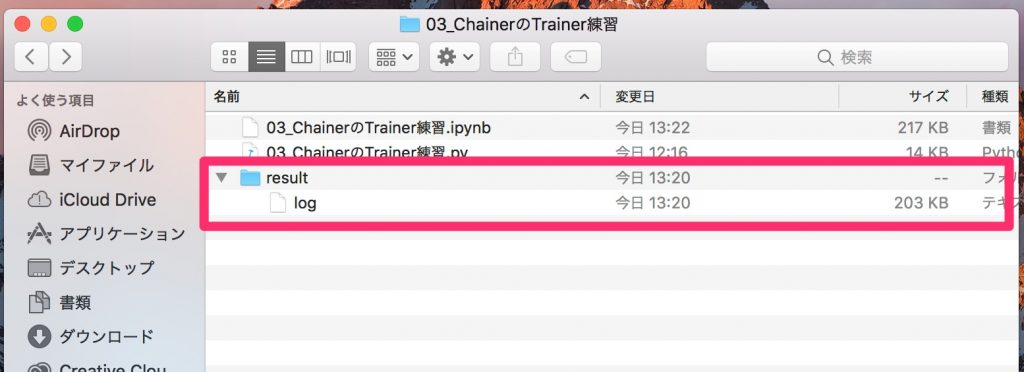

こちらのファイルの中身をエディター（メモ帳）で確認してみると、下記のように格納されていました。
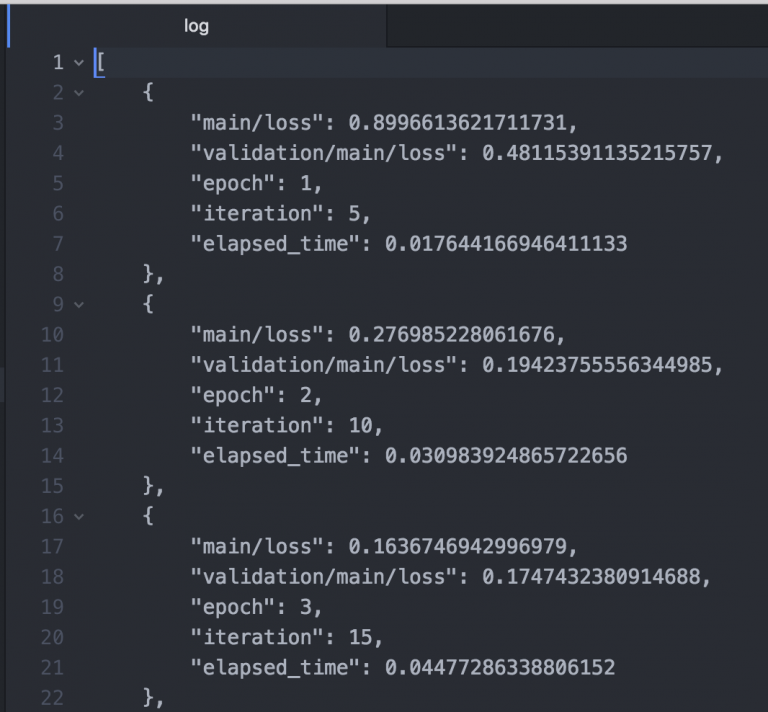

こちらのlogファイルを読み込み、可視化してみましょう。

ファイルの読み込みは以下のように簡単に実装できます

In [181]:
import json
with open('result/log') as f:
     logs = json.load(f)

こちらをlogsという変数名で格納しておくと、辞書型として以下のようにデータにアクセスできます。

## 学習の経過をプロット
まず、プロットするためにリストに変換しておきましょう。

In [182]:
result_train, result_test = [], []
for log in logs:
    result_train.append(log['main/loss'])  # 訓練データ
    result_test.append(log['validation/main/loss'])  # 訓練データ

こちら、Pythonの書き方に慣れている人は以下のように書くこともできます（こちらがPython流）。

In [183]:
result_train = [ log['main/loss'] for log in logs ]
result_test  = [ log['validation/main/loss'] for log in logs ]

こちらだと、空のリストを定義して（[ ]）、そのリストに要素を一つずつ追加して（append）、といった処理を書かなくても良いため、シンプルに書けます。
ただし、最初からこちらの書き方だと難しいため、慣れるまでは前者の書き方で、慣れてきたら後者の書き方にしていきましょう。

プロットはこれまで同様にmatplotlibを使用しますが、今回は凡例（legend）を追加しておきましょう。
plotのオプションにlabelを追加し、plt.legend()を追加することで、凡例が追加されます。

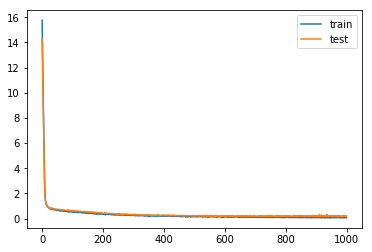

In [184]:
plt.plot(result_train, label='train')  # 訓練データ
plt.plot(result_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

こちらを確認すると、訓練データの損失関数の値が下がりながら、検証データの損失関数の値も下がっているため、**オーバーフィッティング（過学習）**も起こっておらず、理想的な学習ができていることがわかります。

# Part 2. ニューラルネットの学習テクニック (15分)
* NNの最適化手法(Momentum法(MomentumSGD)/AdaGrad/Adam)
* NNの正則化手法(Dropout)
* 勾配消失問題
* XavierとHeの初期化
* Batch Normalization

## Optimizerの種類
既に登場したSGDやAdam含め、Optimizerにはいくつか種類があります。  
詳細は[こちら](https://docs.chainer.org/en/stable/reference/optimizers.html)を御覧ください。
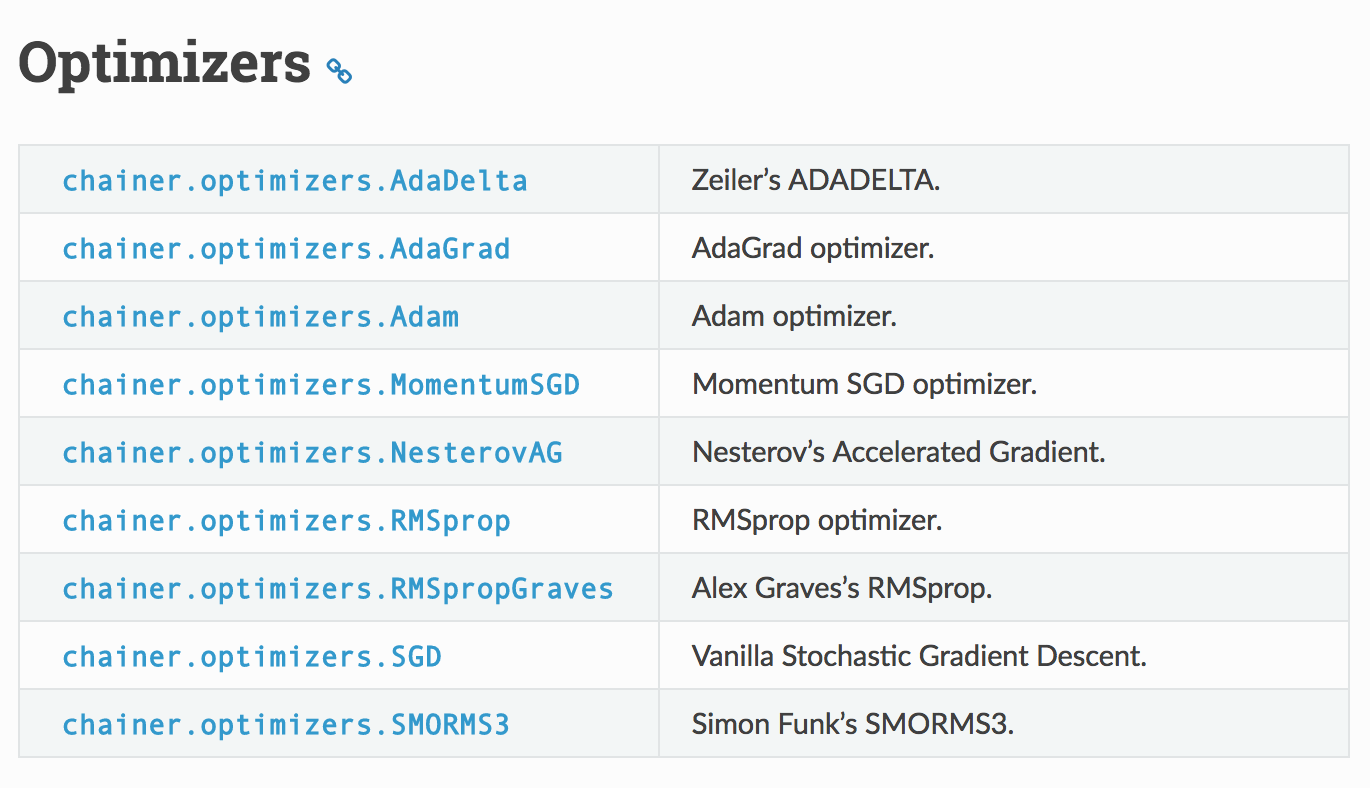

各手法の数式と違いに関しては、下記の記事がわかりやすいです。

[Optimizer : 深層学習における勾配法について](http://qiita.com/tokkuman/items/1944c00415d129ca0ee9)

### SGD（確率的勾配降下法）

In [186]:
optimizer = optimizers.SGD()

### Adam

In [188]:
optimizer = optimizers.Adam()

### モーメンタム

In [190]:
optimizer = optimizers.MomentumSGD()

### AdaGrad

In [191]:
optimizer = optimizers.AdaGrad()

## NNの正則化手法(Dropout)
実データを扱う際にかなり高確率で遭遇する現象として、**NNの過学習（オーバーフィッティング）**があります。
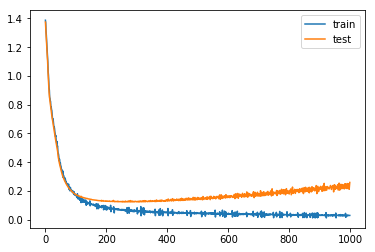

こちらの対策として、**ドロップアウト**があるので、ぜひ覚えておきましょう。
ドロップアウトは、train時に指定してあげるだけで完了です。

In [200]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x, train=True):
        if train:
            h1 = F.dropout( F.relu(self.l1(x)), ratio=0.2)
            h2 = F.dropout( F.relu(self.l2(h1)), ratio=0.2 )
            return self.l3(h2)
        else:
            h1 = F.relu(self.l1(x))
            h2 = F.relu(self.l2(h1))
            return self.l3(h2)

## 勾配消失問題とHeの初期化
reluを使用する際には、Heを使うのが良いと言われていたりする（こちらは経験則）。  
詳しくは、機械学習プロフェッショナルシリーズ参照。

Chainerで通常のLink宣言では、パラメータの値はランダムに決められるため、こちらをHeベースの初期値にする方法を紹介します。

まず、initializer として、以下を定義しましょう。

In [201]:
initializer = chainer.initializers.HeNormal()

こちらの initializer を link 宣言の際に、initialWのオプションで指定します。

In [202]:
chainer.links.Linear(100, 100, initialW=initializer)

## Batch Normalization
性能を向上させる一つの選択肢として、Batch Normalizationがあります。  
こちらをChainerで実装することも非常に簡単です。

In [203]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x):
            h1 = L.BatchNormalization( F.relu(self.l1(x)) )
            h2 = L.BatchNormalization( F.relu(self.l2(h1)) )
            return self.l3(h2)